In [1]:
import math
import os
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import arviz
import stan as pystan

import multiprocessing
multiprocessing.set_start_method('spawn', True)

from cmdstanpy.model import CmdStanModel
from cmdstanpy.utils import cmdstan_path
from scipy.spatial import cKDTree as KDTree
from scipy.stats import entropy, gamma, gaussian_kde, multivariate_normal
#from sklearn.mixture import GaussianMixture
#from sklearn.neighbors import KernelDensity

# from fastkde import fastKDE
# from entropy_estimators import continuous
# import seaborn as sns
# from tqdm.auto import tqdm

/Users/galraz1/opt/miniconda3/envs/stan/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/galraz1/opt/miniconda3/envs/stan/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Helper functions    

In [2]:
def KLdivergence(x, y):
    # Check the dimensions are consistent
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)

    n,d = x.shape
    m,dy = y.shape

    assert(d == dy)

    # Build a KD tree representation of the samples and find the nearest neighbour
    # of each point in x.
    xtree = KDTree(x)
    ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
    thresh = 1e-4
    #r = xtree.query(x, k=100, eps=.01, p=2)[0]
    #s = ytree.query(x, k=100, eps=.01, p=2)[0]

    r = xtree.query(x, k=100, eps=.01, p=2)[0]
    s = ytree.query(x, k=100, eps=.01, p=2)[0]

    r = r[np.arange(r.shape[0]), np.argmax(r > thresh, axis=1)] 
    s = s[np.arange(s.shape[0]), np.argmax(s > thresh, axis=1)]
    
    if math.isinf(-np.log(r/s).sum() * d / n + np.log(m / (n - 1.))):
        a = 0;

    # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
    # on the first term of the right hand side.
    return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

def kl_mvn(m0, S0, m1, S1):
 
  # store inv diag covariance of S1 and diff between means
  N = m0.shape[0]
  iS1 = np.linalg.inv(S1)
  diff = m1 - m0

  # kl is made of three terms
  tr_term   = np.trace(iS1 @ S0)
  det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
  quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
  #print(tr_term,det_term,quad_term)
  return .5 * (tr_term + det_term + quad_term - N) 

def surprisal(dist, sample):
    kde = gaussian_kde(dist)
    prob = kde.evaluate(sample)
    return -np.log(prob)


def EIG(dist, grid, thinning_factor):
        print(np.arange(-1.9, 2, 0.25))
        
        for hypothetical_obs in grid:
            
            data["z"] = np.hstack(np.transpose(sample_data[0:total_samples,:]), hypothetical_obs)

            # get posterior samples
            fit = sm.sampling(data=data, iter=num_iter, chains=1, warmup = num_warmup,control=dict(adapt_delta=0.95));
        
            hyp_posterior = np.hstack((fit['mu'][0:len(fit['mu']):thinning_factor], \
                       fit['sigma'][0:len(fit['mu']):thinning_factor]))
            
            hyp_entropy_reduction = np.abs(continuous.get_h(posterior, k = 200) - continuous.get_h(hyp_posterior, k = 200))
            
            pp =  kde = gaussian_kde(dist)
            prob = kde.evaluate(hypothetical_obs)
            
            EIG += pp * hyp_entropy_reduction
        return EIG
  
  

Build model

In [3]:
# whether to recompile the stan program
DO_COMPILE = True

# simple noise or prior on noise
SIMPLE_NOISE = False

# stan program path
if SIMPLE_NOISE:
    stan_path = 'multi_feature_simple_noise.stan'
    pkl_file = 'model_simple_noise.pkl'
else:
    stan_path = 'multi_feature.stan'
    pkl_file = 'model.pkl'


def build_model(path, pkl_file=None, do_compile=True):
    if do_compile:
        sm = pystan.StanModel(file=path)
        if pkl_file is not None:
            with open(pkl_file, 'wb') as f:
                pickle.dump(sm, f)

    # if the program hasn't been complied, check that the file already exists
    else: 
        if os.path.isfile(pkl_file):
            sm = pickle.load(open(pkl_file, 'rb'))
        else:
            raise FileNotFoundError
    return sm


sm = CmdStanModel(stan_file = 'multi_feature.stan')



Model parameters

In [4]:
# mu
mu_mean = 0
mu_sd = 0.5

# sd
sigma_alpha = 2
sigma_beta = 2


# lower bound of sigma prior
lower_sigma_bound = 0.1

# noise SD prior
noise_alpha = 2
noise_beta = 1

# for simple noise 
noise = 0.4

# environmental information
env_info = 0.07

Create data

In [5]:
# number of stimuli
sequence_length = 6

# number of features 
num_features = 1

# number of samples (max)
num_samples = 3000

# allocation of samples to exemplars
exemplar_idx = np.repeat(np.arange(1, sequence_length+1), num_samples/sequence_length)

# background / deviant mean values
background = np.repeat(1, num_features)
deviant = np.repeat(3, num_features)

# perceptual noise
sig = np.identity(num_features) * 0.001;

# deviant position
deviant_pos = 6

# stimulus means
exemplar_means = np.tile(background, (sequence_length, 1))
exemplar_means[deviant_pos-1] = deviant

Simulation parameters

In [6]:
# number of iterations and warmup per model run
num_iter = 10000
num_warmup = 4000 # can we cash this?

# number of total model runs
num_model_runs = 1

# how much to thin posteriors (value determines how we "retain every nth sample")
thinning_factor = 1

Initialize flags, variables, iterators 

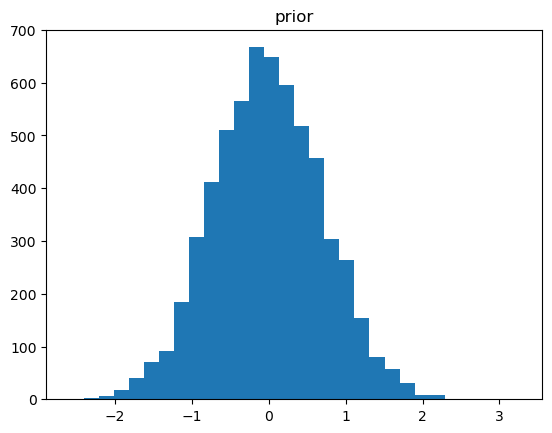

In [7]:
# Flags 
sample = True
policy = 'surprisal' # 'kl', 'surprisal', 'entropy' or 'eig'

# Variables
model_LT = np.zeros((num_model_runs, sequence_length))

# prior parameters
prior_mu = np.random.multivariate_normal(np.repeat(mu_mean, num_features), np.identity(num_features)*mu_sd, num_iter-num_warmup)

prior_sigma = np.empty((num_iter-num_warmup, num_features))
for i in np.arange(0, num_features):
    
    # compute truncated sigma prior
    nrm=gamma.cdf(100, a = sigma_alpha, scale = 1/sigma_beta)- gamma.cdf(lower_sigma_bound, a = sigma_alpha, scale = 1/sigma_beta)
    yr=np.random.rand(num_iter-num_warmup)*(nrm)+gamma.cdf(lower_sigma_bound,  a = sigma_alpha, scale = 1/sigma_beta)
    prior_sigma[:,i] = gamma.ppf(yr, a = sigma_alpha, scale = 1/sigma_beta)
    
    
prior_z_rep = np.empty((num_iter-num_warmup, num_features))
for i in np.arange(0, num_iter-num_warmup):
    prior_z_rep[i,:] = np.random.multivariate_normal(prior_mu[i,:], np.identity(num_features)*prior_sigma[i,:])

prior = np.hstack((prior_mu[0:len(prior_mu):thinning_factor], prior_sigma[0:len(prior_sigma):thinning_factor]))

data = {"mu_mean": mu_mean , "mu_sd": mu_sd, "sigma_alpha": sigma_alpha, "sigma_beta": sigma_beta, 
"noise_alpha": noise_alpha, "noise_beta": noise_beta, "noise": noise, "F": num_features}

stim_info = np.empty((num_model_runs, num_samples))
stim_info[:] = np.nan

plt.hist(prior[:,[0]], bins = 30);
plt.title('prior')
plt.show()

# Action loop

model run:  0


23:48:40 - cmdstanpy - INFO - CmdStan start processing


stimulus:  1
sample:  1


chain 1 |██████████| 00:00 Sampling completed                         


23:48:41 - cmdstanpy - INFO - CmdStan done processing.
23:48:41 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 349 divergent transitions (3.5%)
	Use function "diagnose()" to see further information.



fit.draws
              Mean      MCSE    StdDev        5%       50%       95%  \
lp__     -4.800970  0.025101  1.320790 -7.301850 -4.490260 -3.274330   
mu[1]     0.113657  0.009972  0.487436 -0.679112  0.114472  0.917571   
sigma[1]  0.939474  0.012671  0.629259  0.193361  0.799686  2.161040   
y[1,1]    0.425251  0.015432  0.886299 -1.013350  0.468612  1.778920   
noise     1.608339  0.018548  1.107175  0.311025  1.367710  3.781290   
z_rep[1]  0.398946  0.025416  2.126940 -3.081260  0.563308  3.568030   

                N_Eff       N_Eff/s     R_hat  
lp__      2768.870000   5397.410000  1.000040  
mu[1]     2389.460000   4657.820000  1.000220  
sigma[1]  2466.420000   4807.830000  1.001010  
y[1,1]    3298.690000   6430.200000  0.999928  
noise     3563.214697   6945.837615  1.000115  
z_rep[1]  7003.270000  13651.600000  0.999938  
posterior
[[ 1.09496    0.875953 ]
 [-0.334623   0.955309 ]
 [-0.0456728  1.69019  ]
 ...
 [-0.768272   0.24732  ]
 [-0.927733   0.299909 ]
 [ 0.662

/var/folders/ll/vmwcshdn1xd84d7z8myb9w7m0000gp/T/ipykernel_47067/1323202762.py:76: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('prior', 'posterior')
/var/folders/ll/vmwcshdn1xd84d7z8myb9w7m0000gp/T/ipykernel_47067/1323202762.py:83: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('prior', 'posterior')
/Users/galraz1/opt/miniconda3/envs/stan/lib/python3.9/site-packages/scipy/stats/kde.py:563: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/Users/galraz1/opt/miniconda3/envs/stan/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered

ValueError: array must not contain infs or NaNs

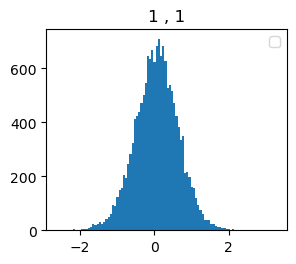

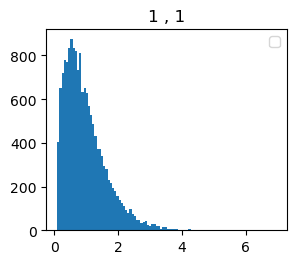

In [9]:
for run in np.arange(0, num_model_runs):
    
    print('model run: ', run)

    # generate the data
    sim_data = [np.random.multivariate_normal(exemplar_means[idx-1], sig) for idx in exemplar_idx] 
    sim_data = np.asmatrix(sim_data)

    # Iterators
    samples_from_current_stim = 1
    total_samples = 1
    exemplar_num = 1

    # initialize data
    sample_data = np.empty((num_samples,num_features))
    sample_data[:] = np.nan

    exemplar_labels = np.empty((num_samples,))
    exemplar_labels[:] = np.nan

    while sample or samples_from_current_stim > 1:
        
        print('stimulus: ', exemplar_num)
        
        print('sample: ', total_samples)

        
        # sample number
        data["M"] = total_samples

        # exemplar number 
        data["K"] = exemplar_num

        # add sim data
        sample_data[total_samples-1] = sim_data[exemplar_idx == exemplar_num][samples_from_current_stim-1]
        data["z"] = np.transpose(sample_data[0:total_samples,:])

        # add exemplar for each id
        exemplar_labels[total_samples-1] = int(exemplar_num)
        data["exemplar_idx"] = [int(x) for x in exemplar_labels[~np.isnan(exemplar_labels)]]

        # get posterior samples
        fit = sm.sample(data=data, iter_sampling=num_iter, chains=1, iter_warmup = num_warmup);
        
        print('fit.draws')
        print(fit.summary())
        
        posterior = np.hstack([fit.stan_variable('mu'), fit.stan_variable('sigma')])
        
        print('posterior')
        print(posterior)

        print('posterior shape')
        print(posterior.shape)

        print('z_rep shape')
        print(fit.stan_variable('z_rep').shape)
        
        print('z_rep is inf')
        print(sum(np.isinf(fit.stan_variable('z_rep'))))

        print('z_rep is nan')
        print(sum(np.isnan(fit.stan_variable('z_rep'))))

        # fit gmms
        #gmm_p = GaussianMixture(n_components=2, random_state=0).fit(posterior)
        #gmm_q = GaussianMixture(n_components=2, random_state=0).fit(prior)

        if total_samples < 20:
            
            plt.figure(1)
            plt.rcParams['figure.figsize'] = [18, 12]
            plt.subplot(4,5,total_samples)
            plt.hist(np.hstack((prior[:,0],posterior[:,0])), bins = 100);
            plt.title(str(total_samples) + " , " + str(exemplar_num))
            plt.legend('prior', 'posterior')
            
            plt.figure(2)
            plt.rcParams['figure.figsize'] = [18, 12]
            plt.subplot(4,5,total_samples)
            plt.hist(np.hstack((prior[:,1],posterior[:,1])), bins = 100);
            plt.title(str(total_samples) + " , " + str(exemplar_num))
            plt.legend('prior', 'posterior')
           
           
        else: 
            plt.show()
            break;
            
        if policy == 'kl':

            X = gmm_p.sample(posterior.shape[0])

            log_p_X = gmm_p.score_samples(X[0])
            log_q_X = gmm_q.score_samples(X[0])

            # KL divergence between prior and posterior
            stim_info[run, total_samples-1] = log_p_X.mean() - log_q_X.mean()
            
            print('KL:',  stim_info[run,total_samples-1])

        elif policy == 'entropy':
            # reduction of entropy
            stim_info[run,total_samples-1] = np.abs(continuous.get_h(prior, k= 250) - continuous.get_h(posterior, k = 250))
            
            print('entropy change:',  stim_info[run,total_samples-1])
            
        elif policy == 'surprisal':   
                            
            # surprisal of current observation given prior
            stim_info[run, total_samples-1] = surprisal(fit.stan_variable('z_rep'), sample_data[total_samples-1])
            
            print('surprisal:',  stim_info[run,total_samples-1])

        elif policy == 'EIG':
            
            hypothethical_grid = np.arange(-2, 2, 0.1)
            
            stim_info[run,total_samples-1] = EIG(posterior)

        # decision rule
        if stim_info[run,total_samples-1] < env_info:
            model_LT[run, exemplar_num-1] = samples_from_current_stim

            # reset/increment counters
            samples_from_current_stim = 1
            exemplar_num += 1

            if exemplar_num > sequence_length:
                sample = False

        else:
            samples_from_current_stim += 1 

        if (policy == 'kl') | (policy == 'surprisal') | (policy == 'entropy'):
            prior = posterior
        
        total_samples += 1

    # start sampling for next model run
    sample = True

    
plt.show()


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

plt.plot(np.arange(1,sequence_length+1), np.mean(model_LT, axis = 0).squeeze(), 'k*')

plt.xlabel("stim index")
plt.ylabel("model samples")
plt.title("")

plt.show()


plt.plot(np.arange(1,total_samples+1),np.mean(stim_info, axis = 0)[0:total_samples].squeeze(), markersize = 20)

plt.xlabel("sample index")
plt.ylabel("stim info")
plt.title("")
plt.show()

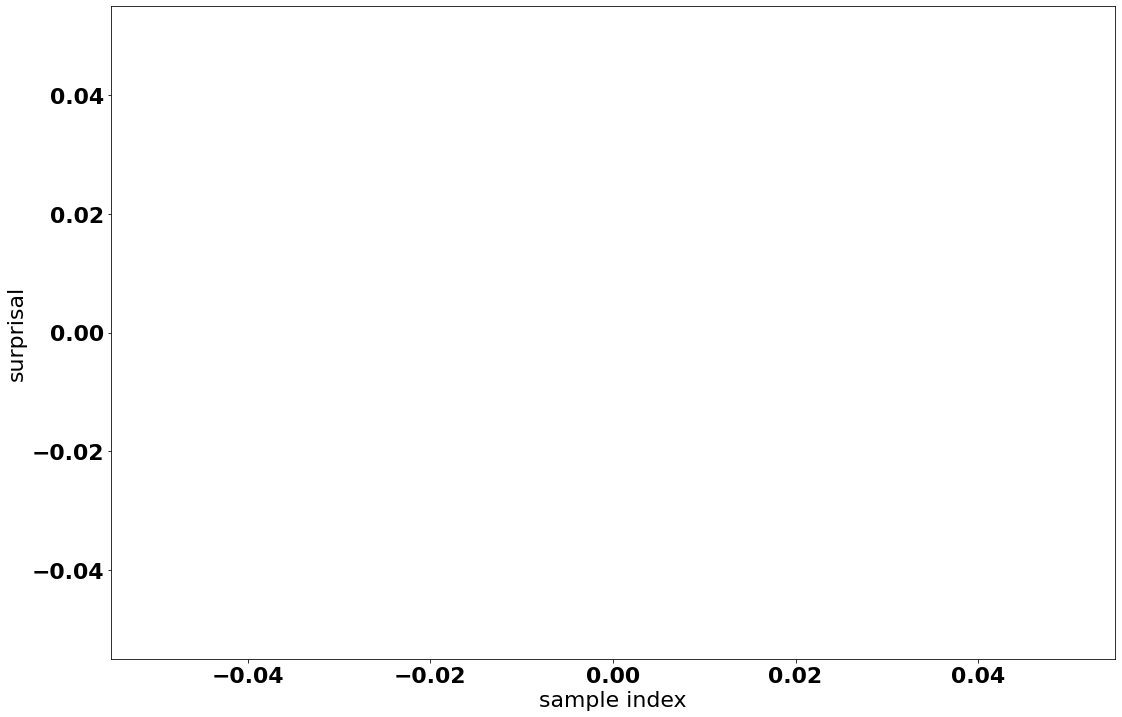

kl div: 1.9389252800833203
means
[0.0029953  1.02672432]
[0.77125344 0.41720897]
SD


NameError: name 'sd_prior' is not defined

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

#plt.plot(np.arange(1,sequence_length+1), np.mean(model_LT, axis = 0).squeeze(), 'k*', markersize = 20)

#plt.xlabel("stim index")
#plt.ylabel("model samples")
#plt.title("")

#plt.show()

plt.plot(np.arange(1,total_samples+1),np.mean(stim_info, axis = 0)[0:total_samples].squeeze(), markersize = 20)

plt.xlabel("sample index")
plt.ylabel("surprisal")
plt.title("")
plt.show()

mean_prior = np.mean(prior, axis = 0)

cov_prior = np.cov(np.transpose(prior))

mean_posterior = np.mean(posterior, axis = 0)

cov_posterior = np.cov(np.transpose(posterior))


print('kl div:', kl_mvn(mean_posterior, cov_posterior, mean_prior, cov_prior))


print("means")

print(mean_prior)
print(mean_posterior)

print("SD")
print(sd_prior)
print(sd_posterior)

print("data")
print(data['z'])
print(data['exemplar_idx'])


data['z']

posterior.shape




In [ ]:
posterior.shape

(16000, 2)

In [ ]:
gmm_p = GaussianMixture(n_components=2, random_state=0).fit(posterior)
gmm_q = GaussianMixture(n_components=2, random_state=0).fit(prior)

X = gmm_p.sample(posterior.shape[0])

log_p_X = gmm_p.score_samples(X[0])
log_q_X, _ = gmm_q.score_samples(X[0])

-3.7146721307353054

means:  [[0.27129736]
 [0.87890242]]
covariances:  [[[0.02682581]]

 [[0.22641521]]]
precisions:  [[[37.27753524]]

 [[ 4.41666434]]]
weights:  [0.70806028 0.29193972]


(0.0, 3500.0)

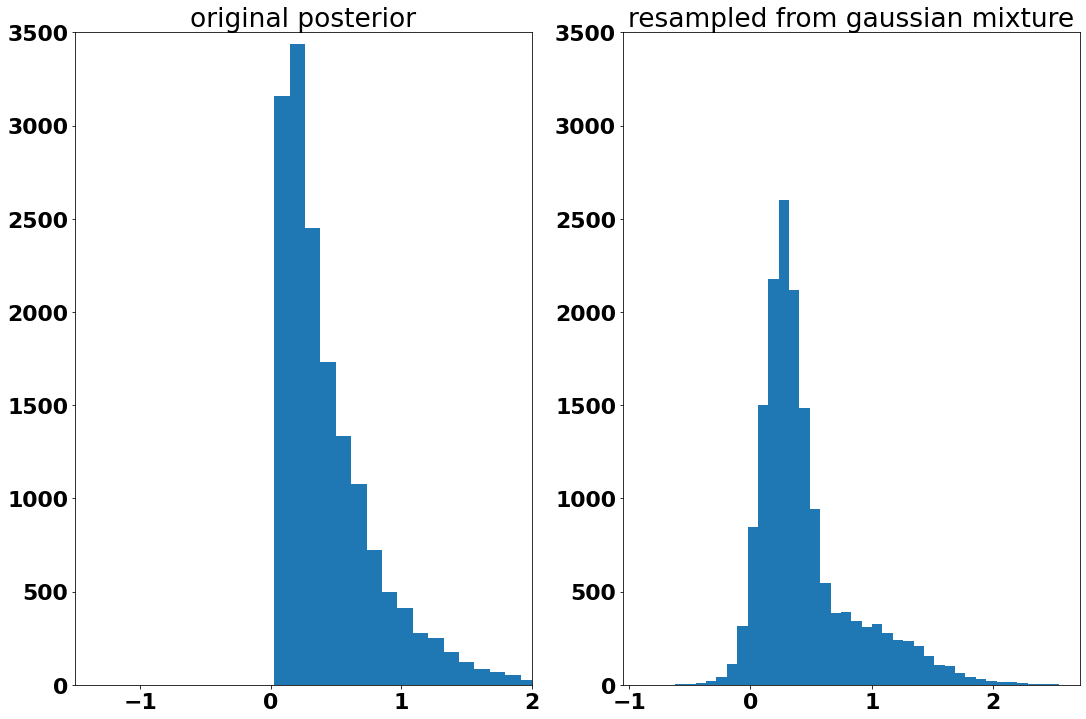

In [ ]:
print('means: ', gm.means_)
print('covariances: ', gm.covariances_)

print('precisions: ', gm.precisions_)

print('weights: ', gm.weights_)


plt.subplot(1,2,1)
plt.hist(posterior[:,1], bins = 40)
plt.title('original posterior')
plt.xlim([-1.5, 2])
plt.ylim([0, 3500])

plt.subplot(1,2,2)
plt.hist(gm.sample(16000)[0], bins = 40)
plt.title('resampled from gaussian mixture')
plt.ylim([0, 3500])


In [ ]:
posterior.shape

(16000, 2)

In [ ]:
model_LT

array([[2., 2., 2., 3., 0., 0.],
       [2., 3., 4., 0., 0., 0.],
       [4., 3., 2., 0., 0., 0.]])

In [ ]:
stim_info[1,0:20]

array([ 2.01619232,  0.00371586,  0.18321453,  0.19169076, -0.01187171,
        0.30167573,  0.0515528 ,  0.14896336, -0.01617405,  0.23803791,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan])

In [ ]:
total_samples

21

In [ ]:
exemplar_num
exemplar_labels

array([ 1.,  1.,  1., ..., nan, nan, nan])

In [ ]:
stim_info.shape

(3, 3000)

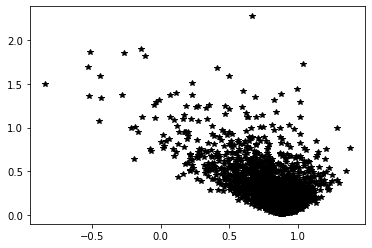

In [ ]:
plt.plot(fit['mu'][0:len(fit['mu']):thinning_factor], fit['sigma'][0:len(fit['mu']):thinning_factor], 'k*')
plt.show()

(array([151., 418., 580., 683., 746., 822., 875., 918., 918., 878., 858.,
        851., 764., 730., 696., 676., 641., 600., 563., 504., 453., 389.,
        391., 322., 353., 293., 257., 244., 250., 211., 203., 171., 164.,
        133., 135., 118., 109.,  96.,  77.,  73.,  79.,  66.,  64.,  45.,
         44.,  36.,  35.,  37.,  32.,  34.,  24.,  17.,  28.,  11.,  19.,
          9.,  12.,  10.,   9.,   8.,   1.,   7.,   4.,   7.,   4.,   4.,
          4.,   3.,   2.,   3.,   1.,   3.,   4.,   2.,   2.,   1.,   1.,
          0.,   0.,   1.,   3.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,
          0.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,   1.,   1.,   0.,
          1.]),
 array([1.60952816e-02, 2.73371299e-01, 5.30647317e-01, 7.87923335e-01,
        1.04519935e+00, 1.30247537e+00, 1.55975139e+00, 1.81702741e+00,
        2.07430342e+00, 2.33157944e+00, 2.58885546e+00, 2.84613148e+00,
        3.10340750e+00, 3.36068351e+00, 3.61795953e+00, 3.87523555e+00,
        4.13251157e+00, 4.3897

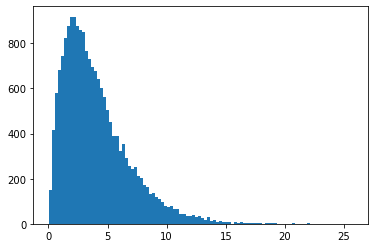

In [ ]:
plt.hist(prior_sigma, bins = 100)